In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.utils
import torchvision.models as models

import cv2

from mamba_model import UMambaBot

import matplotlib.pyplot as plt
import numpy as np

import os

from dice_loss import DiceLoss
import torch.optim as optim
from brain_mri_dataset import BrainMRIDatasetBuilder,BrainMRIDataset

from transforms import BrainMRITransforms

from calculate_iou import calculate_iou
from calculate_dice_score import calculate_dice_score


/share/jccrews/miniconda3/envs/umamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# batch
batch_size = 16

learning_rate = 0.0003

In [4]:
data_dir = "../datasets/lgg-mri-segmentation/kaggle_3m"

builder = BrainMRIDatasetBuilder(data_dir)
df = builder.create_df()
train_df, val_df, test_df = builder.split_df(df)

transform_ = BrainMRITransforms()

train_data = BrainMRIDataset(train_df, transform = transform_ ,  mask_transform= transform_)
val_data = BrainMRIDataset(val_df, transform = transform_ ,  mask_transform= transform_)
test_data = BrainMRIDataset(test_df, transform = transform_ ,  mask_transform= transform_)

train_dataloader = DataLoader(train_data, batch_size = batch_size , shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = batch_size , shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size , shuffle = False)


In [5]:
model = UMambaBot(
    input_channels=3,  # Assuming RGB images with 3 channels
    n_stages=5,
    features_per_stage=(32, 64, 128, 256,512),
    conv_op=nn.Conv2d,  # Assuming 2D convolution
    kernel_sizes=(3, 3, 3, 3, 3),  # Adjusted kernel sizes for 2D convolution
    strides=(1, 2, 2, 2, 2),
    num_classes=1,
    n_conv_per_stage=(1, 1, 1, 1, 1),
    n_conv_per_stage_decoder=(1, 1, 1, 1),
    conv_bias=True,
    norm_op=nn.InstanceNorm2d,  # Assuming 2D instance normalization
    norm_op_kwargs={},
    dropout_op=None,
    nonlin=nn.LeakyReLU,
    nonlin_kwargs={'inplace': True}
).to(device)


In [6]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}')
print(f'Trainable parameters: {trainable_params}')

Total parameters: 9813700
Trainable parameters: 9813700


In [7]:
# Load weights for parallel training
state_dict = torch.load('regular_umamba_weights.pth', map_location=device)
# Remove the 'module.' prefix from keys if present
state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
# Load state dict
model.load_state_dict(state_dict)
model.eval()

# ## Load weights
# model.load_state_dict(torch.load('resnet18_weights.pth'))
# model.eval()

UMambaBot(
  (encoder): ResidualEncoder(
    (stem): StackedConvBlocks(
      (convs): Sequential(
        (0): ConvDropoutNormReLU(
          (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (nonlin): LeakyReLU(negative_slope=0.01, inplace=True)
          (all_modules): Sequential(
            (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (2): LeakyReLU(negative_slope=0.01, inplace=True)
          )
        )
      )
    )
    (stages): Sequential(
      (0): StackedResidualBlocks(
        (blocks): Sequential(
          (0): BasicBlockD(
            (conv1): ConvDropoutNormReLU(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm): InstanceNorm2d(32, eps=1e-0

In [8]:

size_model = 0
for param in state_dict.values():
    if param.is_floating_point():
        size_model += param.numel() * torch.finfo(param.dtype).bits
    else:
        size_model += param.numel() * torch.iinfo(param.dtype).bits
print(f"model size: {size_model} / bit | {size_model / 8e6:.2f} / MB")

model size: 864815232 / bit | 108.10 / MB


In [9]:
def visualize_sample(image, pred_mask, true_mask):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot image
    axes[0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
    axes[0].set_title('Image')
    axes[0].axis('off')
    
    # Plot predicted mask
    axes[1].imshow(pred_mask.squeeze().cpu().numpy(), cmap='gray')  # Adjust vmin and vmax for your classes
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')
    
    # Plot true mask
    axes[2].imshow(true_mask.squeeze().cpu().numpy(), cmap='gray')  # Adjust vmin and vmax for your classes
    axes[2].set_title('True Mask')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

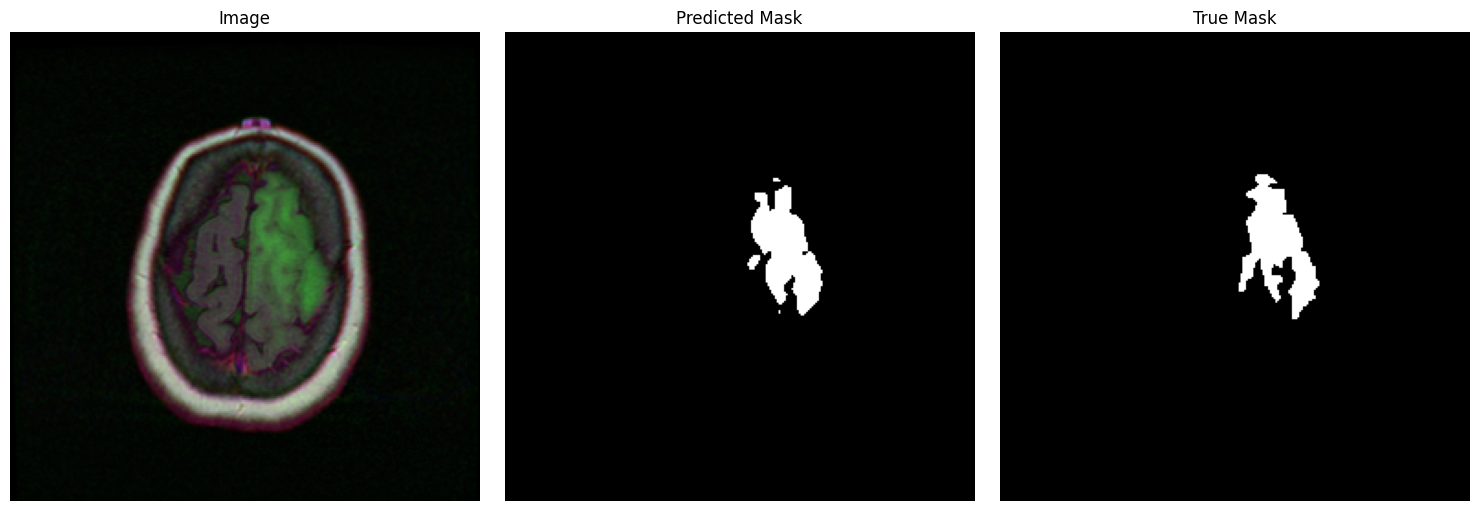

iou: 0.7384361028671265
dice: 0.8495407104492188


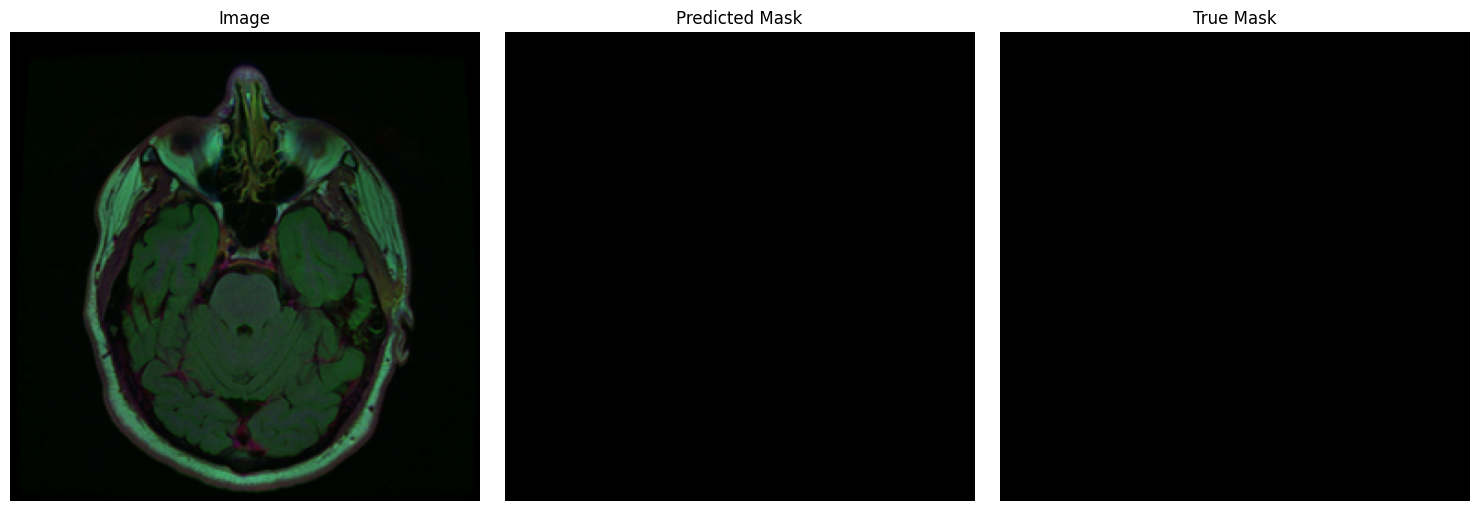

iou: 0.0
dice: nan


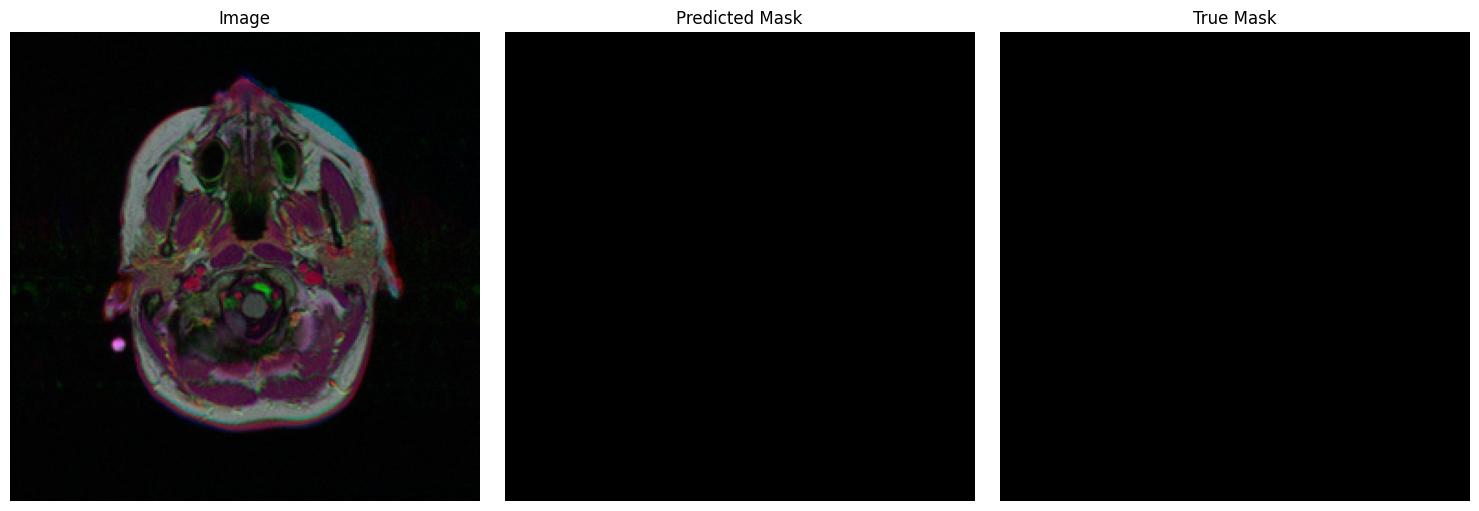

iou: 0.0
dice: nan


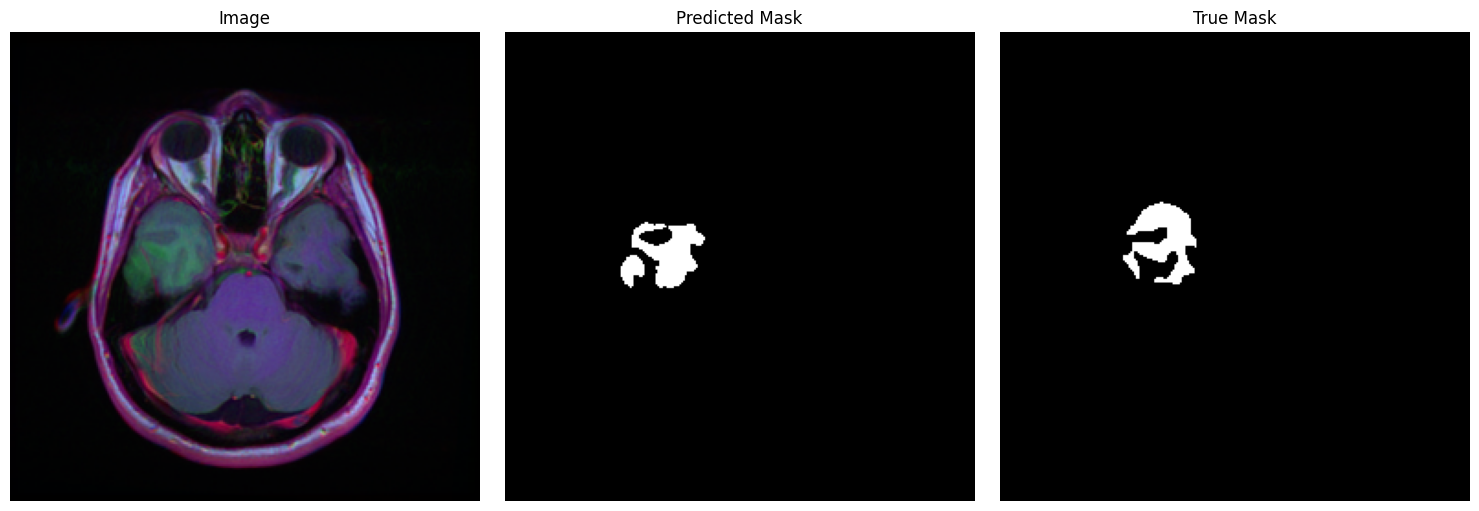

iou: 0.47983869910240173
dice: 0.6485013365745544


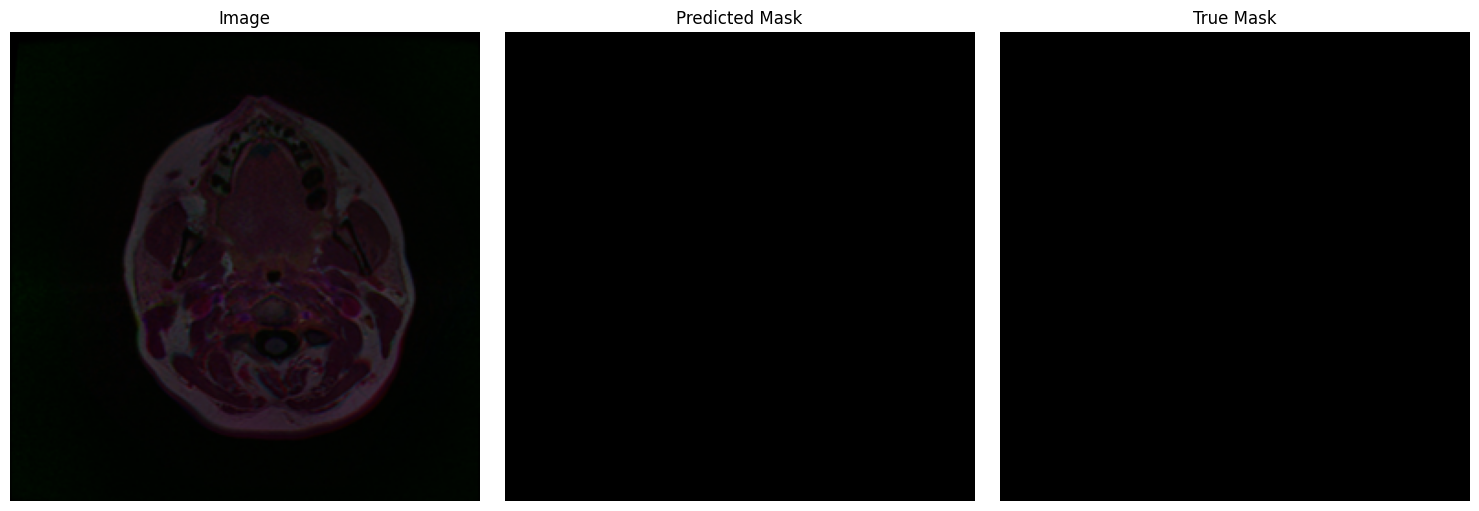

iou: 0.0
dice: nan


KeyboardInterrupt: 

In [10]:
total_iou = 0
total_dice_scrore = 0


with torch.no_grad():
    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device).float(), labels.to(device).float()

        preds = model(imgs)
        preds = torch.where(preds >= 0.5, 1., 0.)

        if (total_iou == 0):
            for k in range(5):
                visualize_sample(imgs[k], preds[k], labels[k])
                iou = calculate_iou(preds[k], labels[k])
                print(f'iou: {iou}')
                dice_score = calculate_dice_score(preds[k], labels[k])
                print(f'dice: {dice_score}')

        iou = calculate_iou(preds, labels)
        # print(f'iou: {iou}')
        total_iou += iou

        dice_score = calculate_dice_score(preds, labels)
        # print(f'dice: {dice_score}')
        total_dice_scrore += dice_score



test_iou = total_iou / len(test_dataloader)
test_dice_score = total_dice_scrore / len(test_dataloader)

print(f'IOU: {test_iou}')
print(f'Dice: {test_dice_score}')